In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Step 1: Data Loading ---
(x_train, _), (x_test, _) = mnist.load_data()
x_train_norm = np.expand_dims(x_train.astype('float32') / 255., axis=-1)
x_test_norm = np.expand_dims(x_test.astype('float32') / 255., axis=-1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# --- Step 2: Create Noisy Data ---
noise_factor = 0.4
x_train_noisy = x_train_norm + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_norm.shape)
x_test_noisy = x_test_norm + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_norm.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [4]:
# --- Step 3: Defining the Denoising Autoencoder (with ReLU) ---
print("\n--- Defining the Denoising Autoencoder Model ---")
latent_dim = 2

# Encoder
input_img = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Flatten()(x)
encoded = layers.Dense(latent_dim, name="latent_space", activation='relu')(x)

# Decoder
x_dec = layers.Dense(7 * 7 * 64, activation='relu')(encoded)
x_dec = layers.Reshape((7, 7, 64))(x_dec)
x_dec = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x_dec)
x_dec = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x_dec)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_dec)

autoencoder = Model(input_img, decoded, name="denoising_autoencoder_relu")
autoencoder.summary()



--- Defining the Denoising Autoencoder Model ---


Model: "denoising_autoencoder_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │         6,274 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,179 (352.26 KB)

 Trainable params: 90,179 (352.26 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# --- Step 4: Training the Model (This will now use the GPU) ---
print("\n--- Training the Denoising Autoencoder ---")

optimizer = tf.keras.optimizers.Adam()   # no jit_compile here
autoencoder.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    jit_compile=False   # <-- put it here if you want to disable JIT
)

autoencoder.fit(
    x_train_noisy, x_train_norm,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test_norm)
)



--- Training the Denoising Autoencoder ---
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 126s 263ms/step - loss: 0.2627 - val_loss: 0.2628
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 254ms/step - loss: 0.2632 - val_loss: 0.2626
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 254ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 117s 250ms/step - loss: 0.2627 - val_loss: 0.2626
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 264ms/step - loss: 0.2631 - val_loss: 0.2625
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 254ms/step - loss: 0.2630 - val_loss: 0.2626
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 255ms/step - loss: 0.2629 - val_loss: 0.2625
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 253ms/step - loss: 0.2631 - val_loss: 0.2626
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 256ms/step - loss: 0.2626 - val_loss: 0.2626
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 254ms/step - loss: 0.2634 - val_loss: 0.2625
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 118s 251ms/ste

In [19]:
print("\n--- Step 5: Generating Images from the Denoising Decoder ---")
num_images_to_generate = 5
mean = 5.0
variance = 1.0
std_dev = np.sqrt(variance)

decoder_input = Input(shape=(latent_dim,), name="decoder_input")
# Start the chain of layers from our new input
decoder_layers_chain = decoder_input
# Loop through the layers of the trained autoencoder, starting from the first layer of the decoder
for i in range(5, len(autoencoder.layers)):
    decoder_layers_chain = autoencoder.layers[i](decoder_layers_chain)

decoder_model = Model(decoder_input, decoder_layers_chain, name="decoder")

random_latent_vectors = np.random.normal(loc=mean, scale=std_dev, size=(num_images_to_generate, latent_dim))
generated_images = decoder_model.predict(random_latent_vectors)


--- Step 5: Generating Images from the Denoising Decoder ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step



Displaying generated images...


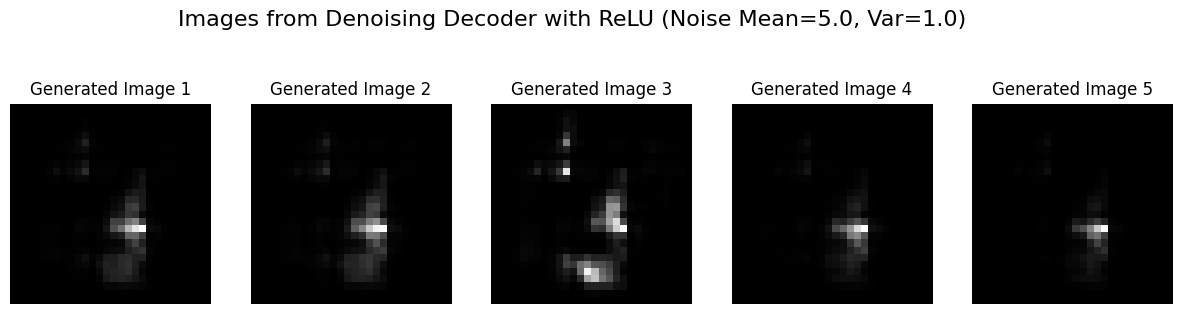

In [20]:
# --- Visualize the Results ---
print("\nDisplaying generated images...")
plt.figure(figsize=(15, 4))
for i in range(num_images_to_generate):
    ax = plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Generated Image {i+1}")
    plt.axis("off")
plt.suptitle(f"Images from Denoising Decoder with ReLU (Noise Mean={mean}, Var={variance})", fontsize=16)
plt.show()